In [73]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import ast
import nltk
nltk.download('punkt')

from source.models import *
from source.preprocessing import *
from source.variables import *
from source.helpers import *

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/constantinernstberger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
#PART = "presentation_summary"
#PART = "qna_summary"
PART = "analysts_summary"

# Initialize columns for each emotion
ORIGINAL = True

df = pd.read_csv("transcripts/credit_df.csv", delimiter="|")

if ORIGINAL:
    emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]
else:
    emotions = ['positive', 'negative', 'ambiguous']

In [75]:
'''Follow intructions on https://github.com/monologg/GoEmotions-pytorch to download the model and tokenizer'''

'''
from transformers import BertTokenizer
from model import BertForMultiLabelClassification
from multilabel_pipeline import MultiLabelPipeline

original = True

if original:
  tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
  model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
else:
  tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-group")
  model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-group")

goemotions = MultiLabelPipeline(
    model=model,
    tokenizer=tokenizer,
    threshold=0.3
)

df[f'{PART}_scores'] = None

# Process each earnings call
for idx, transcript in enumerate(df[PART]):
  try:
    call = nltk.sent_tokenize(transcript)  # Tokenize sentences from the cleaned text
    scores = goemotions(call)  # Assuming `goemotions` processes the sentences and returns emotion scores
    df.at[idx, f'{PART}_scores'] = scores
    print(idx)
  except:
    df.at[idx, f'{PART}_scores'] = []
    print(idx)

df.to_csv(f'goemotions/emotion_scores_{PART}.csv', sep='|')
'''

'\nfrom transformers import BertTokenizer\nfrom model import BertForMultiLabelClassification\nfrom multilabel_pipeline import MultiLabelPipeline\n\noriginal = True\n\nif original:\n  tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")\n  model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")\nelse:\n  tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-group")\n  model = BertForMultiLabelClassification.from_pretrained("monologg/bert-base-cased-goemotions-group")\n\ngoemotions = MultiLabelPipeline(\n    model=model,\n    tokenizer=tokenizer,\n    threshold=0.3\n)\n\ndf[f\'{PART}_scores\'] = None\n\n# Process each earnings call\nfor idx, transcript in enumerate(df[PART]):\n  try:\n    call = nltk.sent_tokenize(transcript)  # Tokenize sentences from the cleaned text\n    scores = goemotions(call)  # Assuming `goemotions` processes the sentences and returns emotion scores\n    

In [76]:
scores = pd.read_csv(f'goemotions/emotion_scores_{PART}.csv', delimiter='|')

# Convert strings in 'presentation_summary_scores' to actual lists
scores[f'{PART}_scores'] = scores[f'{PART}_scores'].apply(ast.literal_eval)

scores.head()

,Unnamed: 0,call_ID,aggregated_RR,presentation,QnA,analysts_summary,analysts_summary_scores
0,0,0,29.023972,Presentation\nOperator\nGood morning Ladies an...,Question and Answer\nOperator\n[Operator Instr...,This is Jennifer Davis in for Todd. Congratula...,"[{'labels': ['neutral'], 'scores': [0.9984401]..."
1,1,1,8.869420,"Presentation\nOperator\nLadies and gentlemen, ...",Question and Answer\nOperator\n(Operator Instr...,Edward Snyder \nThank you very much. Good qua...,"[{'labels': ['gratitude'], 'scores': [0.997841..."
2,2,2,33.210455,Presentation\nOperator\nGreetings ladies and g...,Question and Answer\nOperator\nThank you. Ladi...,"Michael Linenberg \nMerrill Lynch \nHi, yes,...","[{'labels': ['neutral'], 'scores': [0.9723823]..."
3,3,3,11.875000,"Presentation\nOperator\nThank you, all parties...",Question and Answer\nOperator\n[Operator Instr...,Diane Geissler \nMerrill Lynch \nI just want...,"[{'labels': ['neutral'], 'scores': [0.9920691]..."
4,4,4,18.340000,Presentation\nOperator\nThank you for joining ...,Question and Answer\nOperator\n(Operator Instr...,George Staphos \nBanc of America Securities ...,"[{'labels': ['admiration'], 'scores': [0.99529..."


In [77]:
# Initialize columns for each emotion in the DataFrame
for emotion in emotions:
    scores[emotion] = 0.0

# Process each transcript's scores and calculate the emotion features
for idx, row in scores.iterrows():
    # Initialize a dictionary to hold total emotion scores
    emotion_scores = {emotion: 0.0 for emotion in emotions}
    
    # Get the list of sentence scores
    sentence_scores = row[f'{PART}_scores']
    sentence_count = len(sentence_scores)
    
    # Accumulate scores for each emotion
    for entry in sentence_scores:
        for label, score in zip(entry['labels'], entry['scores']):
            if label in emotion_scores:
                emotion_scores[label] += score

    # Normalize the scores by the number of sentences (average per sentence)
    for emotion, total_score in emotion_scores.items():
        scores.at[idx, emotion] = total_score / sentence_count if sentence_count > 0 else 0.0

In [78]:
bond_level = pd.read_csv('transcripts/credit_df.csv', delimiter='|')  

# merge output_df with transcripts on 'transcript_number' and index
bond_level = pd.merge(bond_level,
                          scores[emotions + ['call_ID']],
                          on=['call_ID'],
                          how='left')

# normalize all emotion columns
scaler = MinMaxScaler()
bond_level[emotions] = scaler.fit_transform(bond_level[emotions])

checkpoint = bond_level.copy()

In [79]:
checkpoint.to_csv(f'goemotions/{PART}_final.csv', sep='|')

In [80]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

# Select the supporting features, nlp_lables, and RR from final_df
final_df = checkpoint[['RR']
                    #+ supporting_features_1
                    #+ supporting_features_2
                    + emotions
                    ]

# replace #DIV/0! & Nan with 0
# Replace '#DIV/0!' with NaN
final_df.replace('#DIV/0!', np.nan, inplace=True)
final_df = final_df.fillna(0)

# make sure all values are numeric except for the Date column
final_df = final_df.apply(pd.to_numeric, errors='ignore')

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [81]:
# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     21.87
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           1.42e-73
Time:                        14:24:09   Log-Likelihood:                -4811.5
No. Observations:                1075   AIC:                             9671.
Df Residuals:                    1051   BIC:                             9791.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             61.7457      6.942      8.

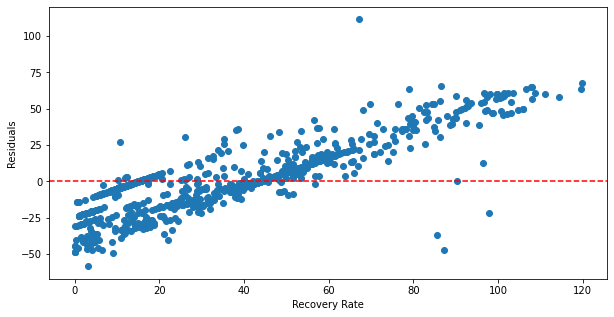

In [82]:
# Bond data 1 + LLM features

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [83]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

          Features         VIF
0            const  112.053470
14       gratitude    4.065389
10     disapproval    3.249590
3        annoyance    3.148246
4         approval    2.726783
7        curiosity    2.611118
5           caring    2.397704
21         remorse    2.231900
23        surprise    2.224208
1       admiration    1.989355
13            fear    1.918212
19     realization    1.856468
16     nervousness    1.832345
22         sadness    1.797013
12      excitement    1.487756
17        optimism    1.386281
8           desire    1.384111
6        confusion    1.358339
9   disappointment    1.205710
20          relief    1.204424
15             joy    1.161026
18           pride    1.147195
2            anger    1.063041
11   embarrassment    1.031412


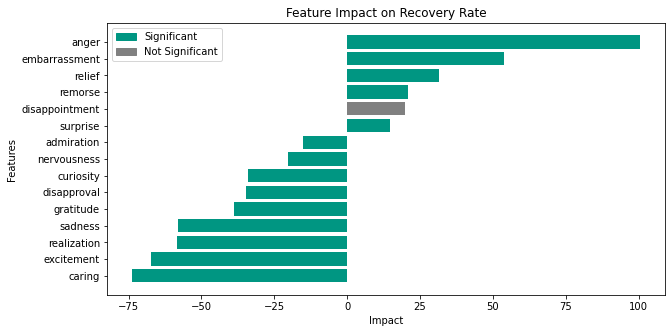

In [86]:
# select significant features
model.significance = model.pvalues[model.pvalues < 0.05].index

# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(15)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# color significant features 0/150/130 and others in grey
colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
# Create a custom legend
handles = [plt.Rectangle((0, 0), 1, 1, color='#009682'), plt.Rectangle((0, 0), 1, 1, color='grey')]
labels = ['Significant', 'Not Significant']
plt.legend(handles, labels)
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Feature Impact on Recovery Rate')
plt.show()

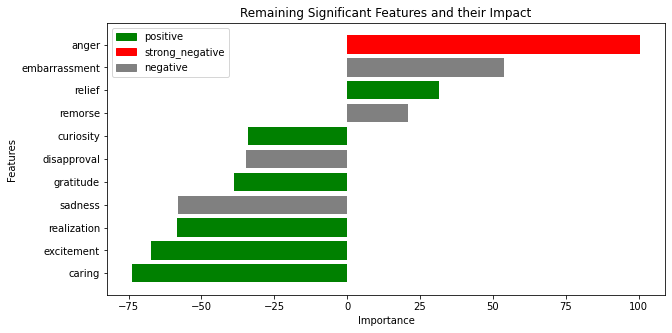

In [85]:
import matplotlib.patches as mpatches

# Filter significant features
significant_features = model.pvalues[model.pvalues < 0.05].index
importances = model.params[significant_features]  # Only significant features
importances = importances[1:]

# Sort importances by their absolute value, and select the top 10
top_10_importances = importances.abs().sort_values(ascending=False).head(11)
importances = importances[top_10_importances.index]
importances = importances.sort_values()  # Sort the values for better visualization

# Define emotion types (assuming the feature names match these emotion labels)
emotion_types = {
    'relief': 'positive',
    'remorse': 'negative',
    'nervousness': 'negative',
    'desire': 'positive',
    'fear': 'strong_negative',
    'excitement': 'positive',
    'confusion': 'negative',
    'pride': 'positive',
    'annoyance': 'negative',
    'gratitude': 'positive',
    'anger': 'strong_negative',
    'optimism': 'positive',
    'sadness': 'negative', 
    'approval': 'positive',
    'caring': 'positive',
    'disappointment': 'negative',
    'curiosity': 'positive',
    'surprise': 'positive',
    'admiration': 'positive',
    'embarrassment': 'negative',
    'realization': 'positive',
    'disapproval': 'negative',
    'joy': 'positive'
}

# Map colors to each emotion type
color_mapping = {
    'positive': 'green',
    'strong_negative': 'red',
    'negative': 'gray',
}

# Apply the color mapping to the top 10 significant features
colors = [color_mapping[emotion_types[emotion]] for emotion in importances.index]

# Create a horizontal bar plot for the top 10 significant features
plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Remaining Significant Features and their Impact')

# Add a legend to the top left corner
handles = [mpatches.Patch(color=color_mapping[emotion], label=emotion) for emotion in color_mapping]
plt.legend(handles=handles, loc='upper left')

# Show the plot
plt.show()